# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)       
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm) 

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.base import clone

<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_behaviour = pickle.load(open("df_behaviour.pkl", 'rb'))

In [43]:
# Creating an assessment table
results_df = pd.DataFrame(columns=["Silhouette_Score", "R2"])
results_df.index.name = 'Method'

# # Initialize an empty DataFrame with explicit data types
# results_df = pd.DataFrame(columns=["Method", "Silhouette_Score", "R2"])
# results_df["Method"] = results_df["Method"].astype(str)
# results_df["Silhouette_Score"] = results_df["Silhouette_Score"].astype(float)
# results_df["R2"] = results_df["R2"].astype(float)
# results_df.set_index('Method', inplace=True)

In [ ]:
# Outliers for the segmentation with DBSCAN
# Normalize the features
scaler = StandardScaler() # using standard scaler because we still have a lot of outliers
X_scaled = scaler.fit_transform(df_behaviour.values)

dbscan = DBSCAN(eps=2, min_samples=3)  
labels = dbscan.fit_predict(X_scaled)

outlier_indices = np.where(labels == -1)[0]
df_behaviour_noscale = df_behaviour.drop(index=df_behaviour.iloc[outlier_indices].index)

print(f"Number of rows after outlier removal: {df_behaviour.shape[0]}")
print(f"Total number of outliers removed: {len(outlier_indices)}")
df_behaviour = pd.DataFrame(df_behaviour)

Number of rows after outlier removal: 31736
Total number of outliers removed: 71


In [5]:
scaler = MinMaxScaler()

df_behaviour = df_behaviour_noscale.copy()
numeric_columns = df_behaviour.select_dtypes(include=['float64', 'int64', 'Int64']).columns
df_behaviour = scaler.fit_transform(df_behaviour)
df_behaviour = pd.DataFrame(df_behaviour)

<a class="anchor" id="clustering">
    
## 3. Clustering
</a>


### Function for plotting R2 for various hierarchical methods

In [6]:
# para apagar
def get_r2_kmeans(df, kmeans, max_nclus, min_nclus=2):
    
    r2 = {}
    for n_clusters in range(min_nclus, max_nclus + 1):
        clusterer = clone(kmeans).set_params(n_clusters=n_clusters)
        labels = clusterer.fit_predict(df)
        df_with_labels = df.copy()
        df_with_labels['labels'] = labels
        r2[n_clusters] = get_r2(df_with_labels, 'labels')
    return np.array(list(r2.values()))

In [17]:
def get_ss(df):
    
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def get_r2(df, labels):
    sst = get_ss(df)  
    ssw_labels = df.groupby(labels).apply(get_ss)  
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst 
    return r2
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
   
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust

<a class="anchor" id="hierarchical">
    
## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

Hierarchical clustering creates a hierarchy of clusters by either starting with all points in a single cluster and splitting them recursively (divisive) or by starting with each point in its own cluster and merging them (agglomerative). In this project, we are going to use agglomerative clustering.

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### 3.1.1 Defining the best linkage method and the best partitioning method (based on the $R^2$)

The linkage method determines how the distance between clusters is calculated.
- Ward: Minimizes the variance within clusters.
- Complete: Considers the maximum distance between points in two clusters.
- Average: Uses the average distance between points in two clusters.
- Single: Considers the minimum distance between points in two clusters.

The highest $R^2$ in a model implies that this explains better the data. In our case, the best hierarchical linkage is Ward.

In [8]:
# este erro é propositado para nao correrem o bloco de codigo abaixo, demora 70 min a correr, corram so o outro a seguir
erro = 

SyntaxError: invalid syntax (476420837.py, line 2)

In [ ]:
# Set up the clusterers

kmeans = KMeans(init='k-means++', n_init=20, random_state=42)
hierarchical = AgglomerativeClustering(metric='euclidean')

In [10]:
# Obtaining the R² scores for each cluster solution on behaviour variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_behaviour, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: 
    r2_scores[linkage] = get_r2_scores(
        df_behaviour, hierarchical.set_params(linkage=linkage))

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.630808,0.165471,0.076001,0.000588,0.529229
3,0.744112,0.170928,0.077733,0.000765,0.724775
4,0.808090,0.172336,0.079034,0.000912,0.774195
5,0.835129,0.625549,0.667481,0.001073,0.819098
6,0.853270,0.632541,0.667631,0.002346,0.836128
7,0.865100,0.641682,0.667771,0.003650,0.845993
8,0.875648,0.643144,0.670391,0.005229,0.854365
9,0.883784,0.644240,0.733604,0.005235,0.861761


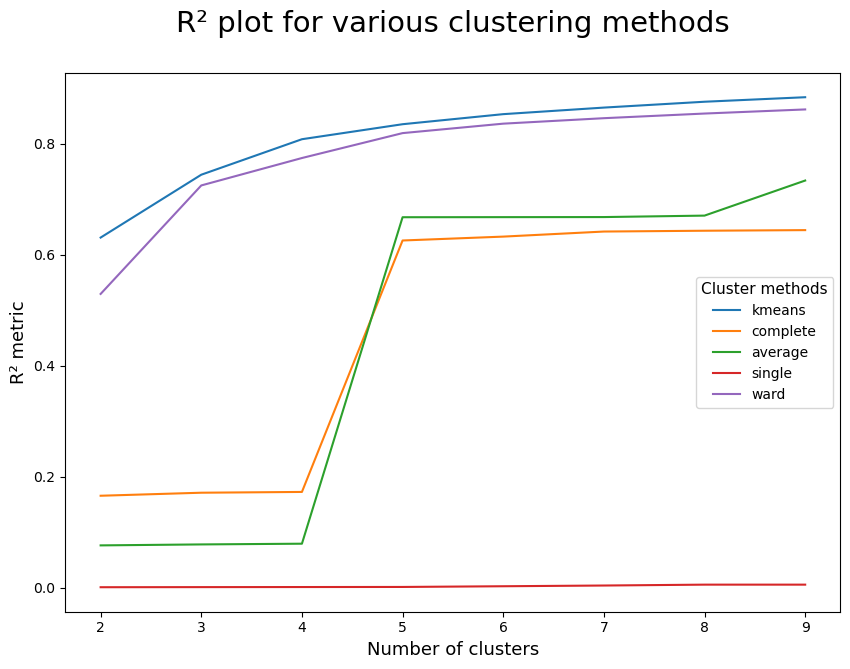

In [11]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("R² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

A dendrogram is a tree-like diagram that is used to illustrate the arrangement of clusters created by hierarchical clustering. It represents how data points (or clusters) are merged step-by-step in the hierarchical clustering process. Dendrograms are useful for the following purposes:

- **Visualizing Cluster Relationships**: It shows how clusters are formed and how closely they are related to one another.
- **Determining the Optimal Number of Clusters**: By cutting the dendrogram at a specific height, it is possible to identify the ideal number of clusters. The height reflects the threshold of similarity or distance.

A dendrogram shows how clusters are merged at each step. By cutting the dendrogram at a specific height, we can define the number of clusters. <br>
Analyzing this dendrogram, we can see a clear separation with 3 clusters, making them potential candidates for the optimal number of clusters.

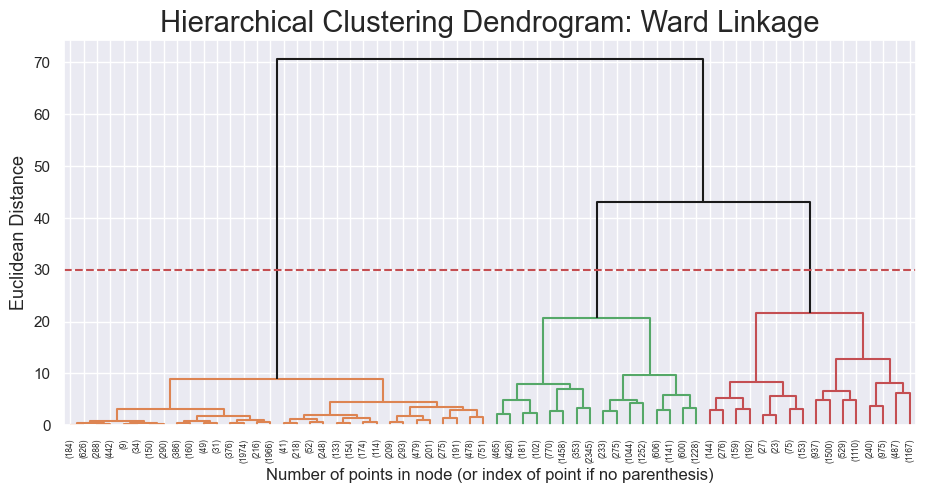

In [12]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_behaviour)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 3.1.2. Hierarchical Clustering - Silhouette Score 

The **silhouette score** helps us assess how well the data points fit into their assigned clusters. It looks at two things: 

- **Cohesion**: How close points are to others in the same cluster.
- **Separation**: How far points are from clusters that are different.

A **higher silhouette score** (closer to 1) means that the clusters are well-defined, with points tightly grouped together and clearly separated from other clusters. A **lower score** (close to 0) suggests that the clusters may overlap, while a **negative score** indicates points might have been placed in the wrong cluster.

By looking at the silhouette score for different numbers of clusters, we can pick the number of clusters that gives the **best score** that can be seen by the higher silhouete score. The goal is to have the less negatives possible, because positives mean that each point correctly belongs to the cluster that it was assigned to.

For hierarchical clustering, the highest silhouette score was observed with 2 clusters, indicating it is the best choice in this case.

In [ ]:
# Compute silhouette score for different n_clusters
for n_clusters in [2, 3, 4]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_behaviour)
    silhouette_avg = silhouette_score(df_behaviour, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 0.4647136558248964
Silhouette Score for 3 clusters: 0.43469847498950737
Silhouette Score for 4 clusters: 0.42730107830015945
Silhouette Score for 5 clusters: 0.3785203401803003


### 3.1.4. Hierarchical Clustering - Final Solution

After the analysis of the sillouete score we conclude that the optimal amount of clusters is either 2 or 3. As the results for this clustering seem to be good, we will assess both the options along with the other clusterings.

In [38]:
# solution with 2 clusters

hc2_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=2)
hc2_labels = hc2_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc2_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

,0,1,2,3,4,5
hierarc_labels,,,,,,
0,0.087841,0.080151,0.589604,0.089047,0.093300,0.164270
1,0.031400,0.012384,0.032528,0.021472,0.025694,0.027796


In [39]:
r2 = get_r2(df_behaviour, hc2_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, hc2_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_2"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R^2 Score: 0.5292288663751318
Silhouette Score: 0.4647136558248964


In [40]:
# solution with 3 clusters

hc3_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc3_labels = hc3_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc3_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

,0,1,2,3,4,5
hierarc_labels,,,,,,
0,0.127865,0.131509,0.822582,0.136168,0.144887,0.248607
1,0.031400,0.012384,0.032528,0.021472,0.025694,0.027796
2,0.062202,0.047251,0.440359,0.058861,0.060254,0.110243


In [41]:
r2 = get_r2(df_behaviour, hc3_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, hc3_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_3"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R^2 Score: 0.7247753456836725
Silhouette Score: 0.43469847498950737


<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>


### 3.2.1.K- Means - Inertia ( Defining the number of cluster)

Inertia measures how well data points fit into clusters by summing the squared distances between points and their nearest cluster centroid (**SSW**). 

- **Lower inertia**: Clusters are more compact, it's better because it means the datapoints are similar to each other.
- **Higher inertia**: Clusters are less defined.

Using the **elbow method**, we plot inertia for 1 to 10 clusters and look for the "elbow"—the point where inertia stops decreasing significantly. This indicates the optimal number of clusters.

Observing the following Inertia plot. We conclude that the optimal number of clusters is 2 or 3. We will investigate this further with other methods.lot.ters.

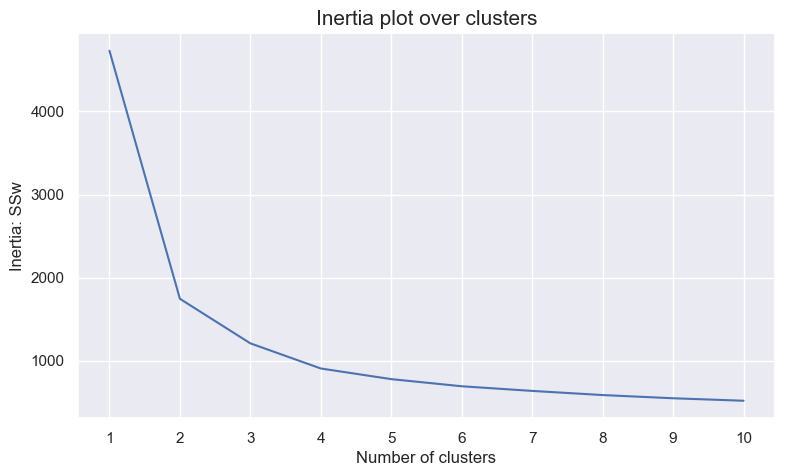

In [21]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_behaviour)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

### 3.2.2. K- Means - Silhouete Score (Defining the number of clusters)

As we saw previously, the silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters. By computing silhouette scores for different numbers of clusters, we can determine the best number of clusters. <br>

The highest silhouette coeficient was obtained with 2 clusters, as it's possible to see.

For n_clusters = 2, the average silhouette_score is : 0.5459361622802875
For n_clusters = 3, the average silhouette_score is : 0.460285892660443
For n_clusters = 4, the average silhouette_score is : 0.45032433874868916
For n_clusters = 5, the average silhouette_score is : 0.40232869374345065
For n_clusters = 6, the average silhouette_score is : 0.3932596204930875
For n_clusters = 7, the average silhouette_score is : 0.3946230212913903


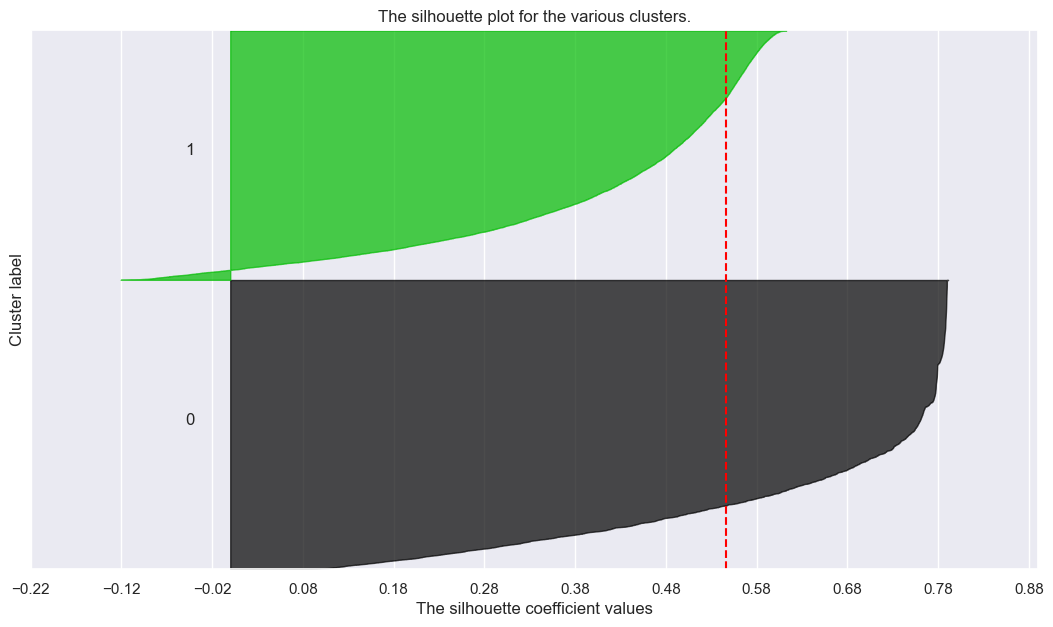

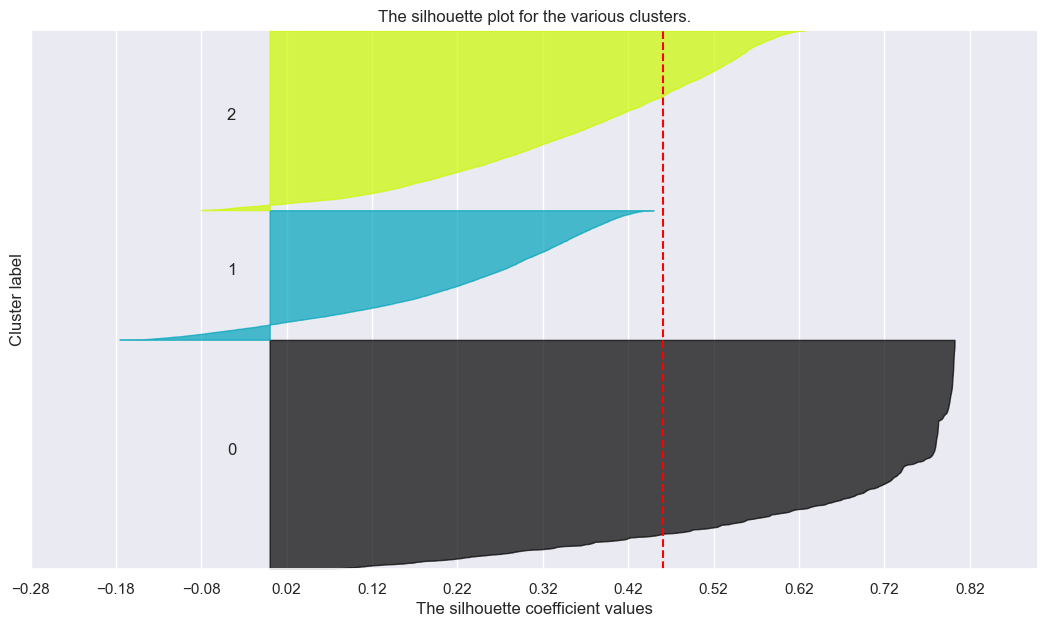

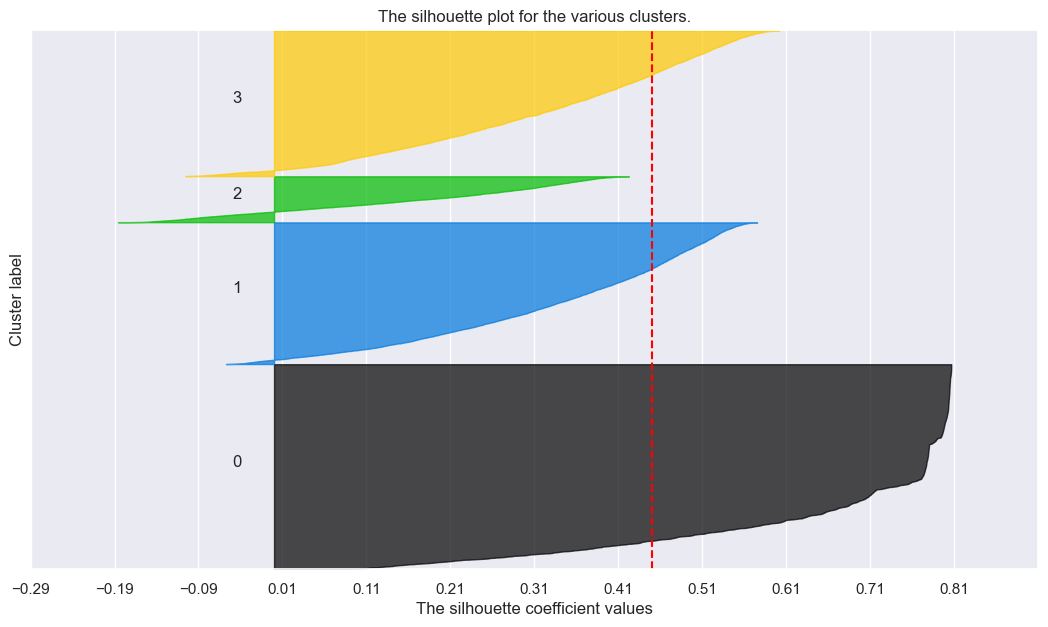

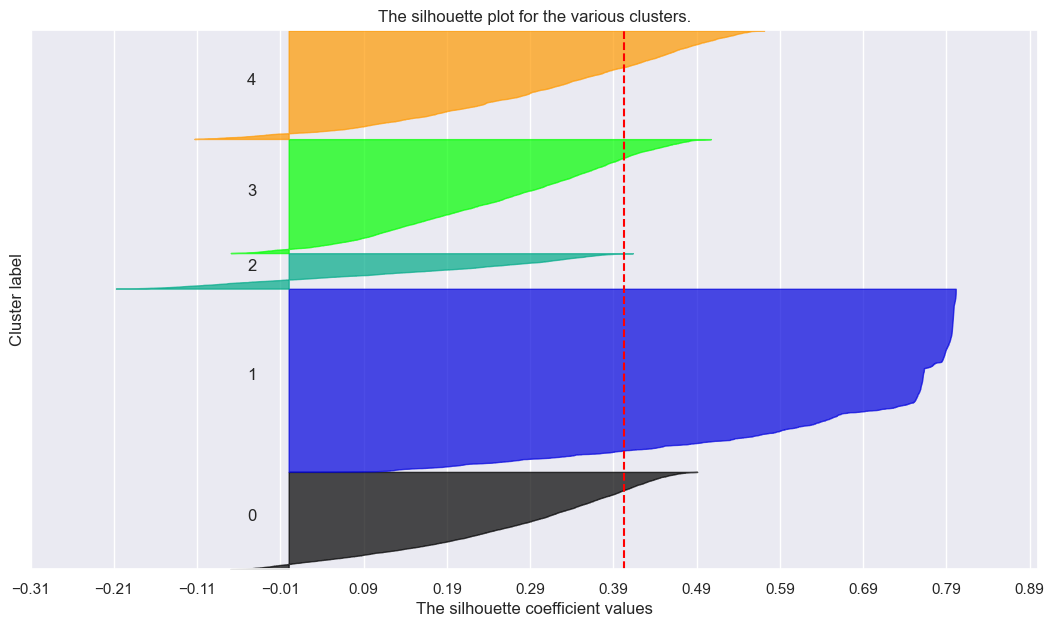

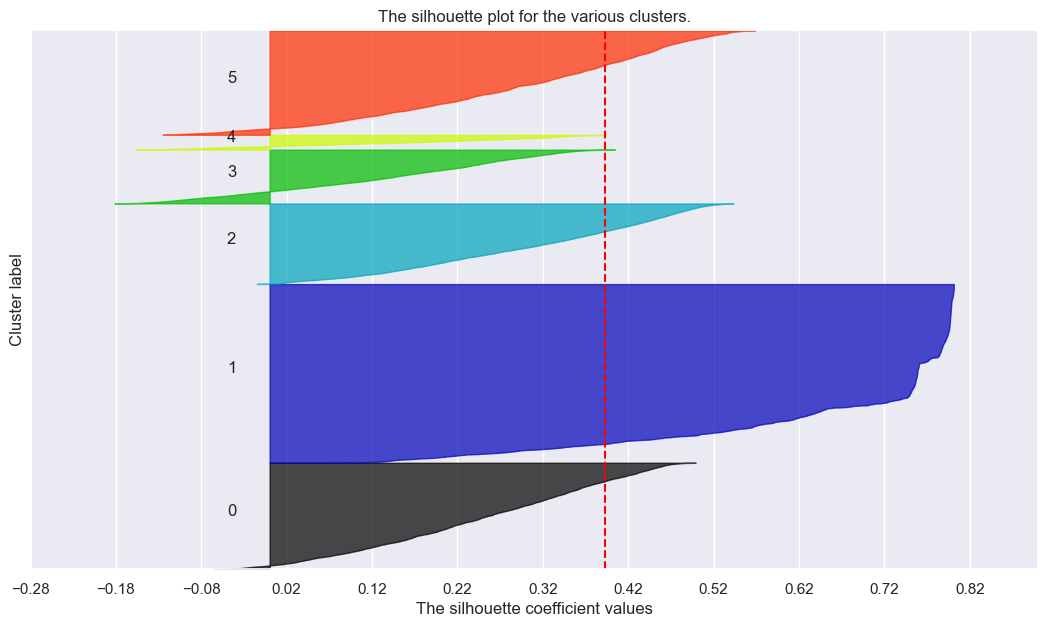

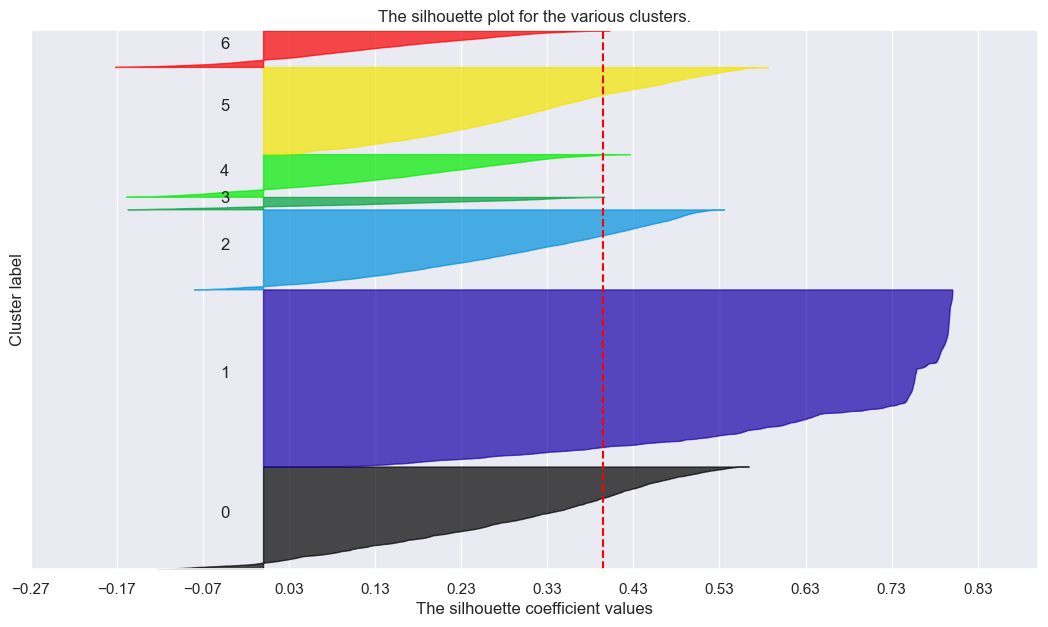

In [22]:
avg_silhouette = []
for nclus in range(2, 8):  # Loop from 2 to 7 clusters
    fig = plt.figure(figsize=(13, 7))
    
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_behaviour)

    silhouette_avg = silhouette_score(df_behaviour, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df_behaviour, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() - 0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(df_behaviour) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

plt.show()


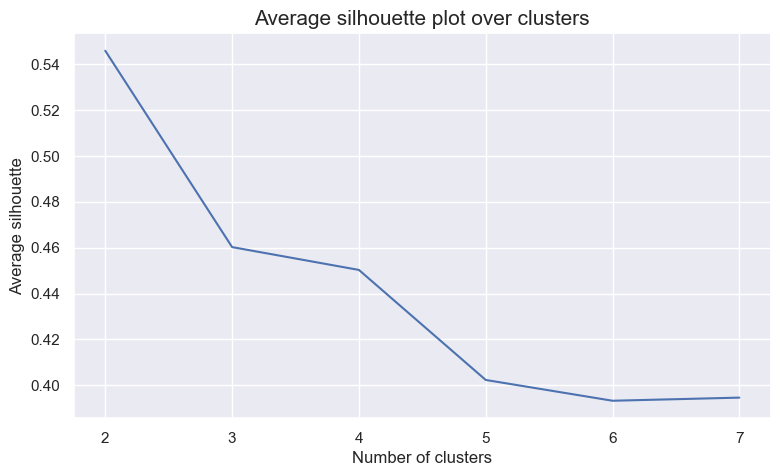

In [23]:
plt.figure(figsize=(9, 5))
plt.plot(range(2, 8), avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.xticks(range(2, 8)) 
plt.show()

### 3.2.3. K- Means - R^2 (Defining the number of clusters)
Using R² helps assess the effectiveness of the clustering, with higher values indicating better-defined clusters. However, it does not account for cluster shape, so it should be used with other metrics.

In [24]:
# def get_r2_kmeans(df, max_nclus, min_nclus=1, random_state=42):    
#     r2 = []  # where we will store the R2 metrics for each cluster solution
#     feats = df.columns.tolist()
    
#     for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
#         kmeans = KMeans(n_clusters=i, random_state=random_state)
        
#         # get cluster labels
#         labels = kmeans.fit_predict(df)
        
#         # concat df with labels
#         df_concat = pd.concat([df, pd.Series(labels, name='labels', index=df.index)], axis=1)
        
#         # append the R2 of the given cluster solution
#         r2.append(get_r2(df_concat, 'labels'))
        
#     return np.array(r2)
# n_initializations = 5  # number of different random initializations to try
# max_nclus = 10

# r2_kmeans = np.vstack([get_r2_kmeans(df_behaviour, 
#                                     max_nclus=max_nclus, 
#                                     min_nclus=1, 
#                                     random_state=seed) 
#                                     for seed in range(n_initializations)])
# # Create DataFrame with all initializations
# r2_kmeans_df = pd.DataFrame(
#    r2_kmeans.T,
#    index=range(1, max_nclus + 1),
#    columns=[f'init_{i}' for i in range(n_initializations)]
# )

# # Add mean and std columns
# r2_kmeans_df['mean_R2'] = r2_kmeans_df.mean(axis=1)
# r2_kmeans_df['std_R2'] = r2_kmeans_df.std(axis=1)
# sns.set()

# # Plot data
# fig = plt.figure(figsize=(11,5))

# # Plot individual initializations with lower alpha for less visual clutter
# for i in range(n_initializations):
#     plt.plot(r2_kmeans_df.index, r2_kmeans_df[f'init_{i}'], 
#              alpha=0.3, color='gray', linestyle='-', linewidth=1)

# # Plot mean with confidence band
# sns.lineplot(data=r2_kmeans_df['mean_R2'], linewidth=2.5, marker='o', 
#              label='Mean R²', color='blue')

# # Add confidence band
# plt.fill_between(r2_kmeans_df.index,
#                  r2_kmeans_df['mean_R2'] - r2_kmeans_df['std_R2'],
#                  r2_kmeans_df['mean_R2'] + r2_kmeans_df['std_R2'],
#                  alpha=0.2, color='blue', label='±1 std dev')

# # plot
# plt.legend(title="K-means", title_fontsize=11)
# plt.xticks(range(1, max_nclus + 1))
# plt.xlabel("Number of clusters", fontsize=13)
# plt.ylabel("R² metric", fontsize=13)

# fig.suptitle("$R^2$ plot for K-means clustering", fontsize=21)

# plt.show()

### 3.2.4. K-Means Optimal clusters
After the analysis of the sillouete score and the inertia plot we conclude that the optimal amount of clusters is either 2 or 3. As the results for this clustering seem to be very good, we will assess both the options along with the other clusterings.
#### 2 clusters

In [25]:
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)

df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,0,1,2,3,4,5
labels,,,,,,
0,0.038156,0.020264,0.124206,0.030923,0.033380,0.048706
1,0.102363,0.097855,0.703957,0.104854,0.111166,0.194080


In [26]:
r2 = get_r2(df_behaviour, km_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_2"])

# Add the new row to the DataFrame using pd.concat
results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R^2 Score: 0.630807503142525
Silhouette Score: 0.5459361622802875


#### 3 clusters

In [27]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)


df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,0,1,2,3,4,5
labels,,,,,,
0,0.034530,0.015759,0.064713,0.026277,0.028548,0.036068
1,0.137072,0.140538,0.827411,0.144289,0.152864,0.257403
2,0.060590,0.046999,0.497840,0.057737,0.061372,0.116153


In [28]:
r2 = get_r2(df_behaviour, km_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_3"])

# Add the new row to the DataFrame using pd.concat
results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R^2 Score: 0.7441150107692106
Silhouette Score: 0.460285892660443


<a class="anchor" id="som">
    
## 3.3. SOM
</a>


In [ ]:
def calculate_topographic_error(som, data):
    """Calculate the topographic error for a SOM."""
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)  
        distances = np.linalg.norm(som._weights - sample, axis=-1)  
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)  
        
        # Check if BMU 1 and BMU 2 are neighbors
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    
    return errors / len(data)

def get_neighbors_hexagonal(som, node):
    """Get hexagonal neighbors of a node in the SOM."""
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal

def train_and_evaluate_som(data, M=30, N=30, learning_rate=0.5, sigma=3.0, neighborhood_function='gaussian', topology='hexagonal', random_seed=42):
    """Train a SOM and calculate QE and TE before and after training."""
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=learning_rate, 
                  neighborhood_function=neighborhood_function, topology=topology, random_seed=random_seed)
    
    som.random_weights_init(data)
    print("Before training:")
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_before}, TE: {te_before}")
    
    som.train_batch(data, 20000)  
    
    print("After training:")
    qe_after = np.round(som.quantization_error(data), 4)
    te_after = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE: {qe_after}, TE: {te_after}")
    
    return som, qe_before, te_before, qe_after, te_after

def run_multiple_soms(data, learning_rates, sigmas, M=30, N=30, iterations=20000, w1=1, w2=1):
    """Run SOM training for multiple configurations of learning rates and sigmas."""
    results_after = []
    
    print("Evaluating errors before training:")
    n_features = data.shape[1]
    som = MiniSom(M, N, n_features, sigma=3.0, learning_rate=0.5, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
    som.random_weights_init(data)
    qe_before = np.round(som.quantization_error(data), 4)
    te_before = np.round(calculate_topographic_error(som, data), 4)
    print(f"QE Before Training: {qe_before}")
    print(f"TE Before Training: {te_before}")
    
    print("\nTraining SOMs for all configurations:")
    for lr in learning_rates:
        for sigma in sigmas:
            print(f"\nTraining SOM with learning_rate={lr}, sigma={sigma}")
            som = MiniSom(M, N, n_features, sigma=sigma, learning_rate=lr, neighborhood_function='gaussian', topology='hexagonal', random_seed=42)
            som.random_weights_init(data)
            som.train_batch(data, iterations)
            
            qe_after = np.round(som.quantization_error(data), 4)
            te_after = np.round(calculate_topographic_error(som, data), 4)
            print(f"After Training - QE: {qe_after}, TE: {te_after}")
            
            results_after.append({
                'Learning Rate': lr,
                'Sigma': sigma,
                'QE After': qe_after,
                'TE After': te_after
            })

    after_df = pd.DataFrame(results_after)

    after_df['Score'] = w1 * after_df['QE After'] + w2 * after_df['TE After']
    best_config = after_df.loc[after_df['Score'].idxmin()]  

    print("\nBest Configuration:")
    print(f"Learning Rate: {best_config['Learning Rate']}, Sigma: {best_config['Sigma']}")
    print(f"QE After: {best_config['QE After']}, TE After: {best_config['TE After']}, Score: {best_config['Score']}")
    
    return after_df, best_config

Visualization with different SOM parameters

Finding the best choice of parameters and training the SOM

c:\Users\marsi\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


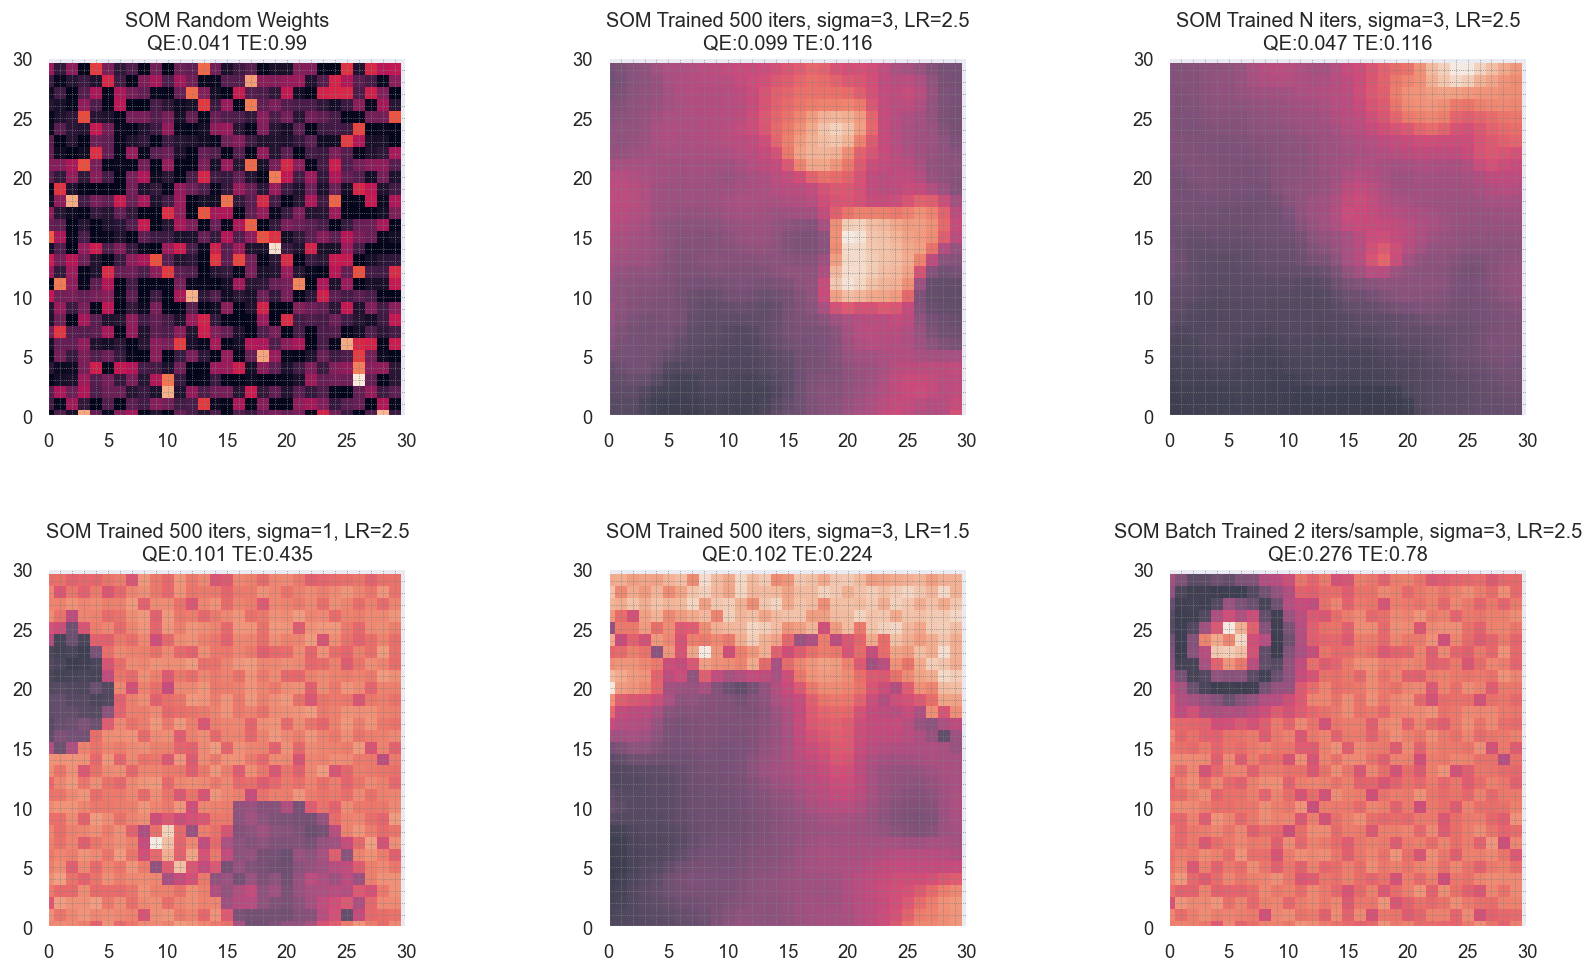

In [ ]:
M, N = 30, 30
som_data_behaviour = df_behaviour.values 
input_len = som_data_behaviour.shape[1]  

som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.random_weights_init(som_data_behaviour)

fig, axes = plt.subplots(2, 3, figsize=(14, 8), gridspec_kw={'hspace': .15}, constrained_layout=True, dpi=120)
colors_dims = (30, 30)
major_ticks = np.arange(0, M + 1, 5)
minor_ticks = np.arange(0, M + 1, 1)

################################
## Helper Function
################################
def tidy_ax(ax, major_ticks, minor_ticks, grid_size):
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='both', color='gray', linestyle=':', linewidth=0.5)
    ax.set_xlim([0, grid_size])
    ax.set_ylim([0, grid_size])
    return ax

################################
## Random Weights
################################
ax = axes[0][0]
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower")  # Mean of weights for visualization
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Random Weights\nQE:{qe} TE:{te}")

################################
## Trained SOM - 500 Iterations
################################
ax = axes[0][1]
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Fully Trained SOM
################################
ax = axes[0][2]
som_c.train(som_data_behaviour, len(som_data_behaviour), random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained N iters, sigma=3, LR=2.5\nQE:{qe} TE:{te}")

################################
## Other Configurations (Optional)
################################

# SOM with sigma=1
ax = axes[1][0]
som_c = MiniSom(M, N, input_len, sigma=1., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75)  # Mean of weights
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=1, LR=2.5\nQE:{qe} TE:{te}")

# SOM with learning rate=1.5
ax = axes[1][1]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=1.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 500, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75) 
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Trained 500 iters, sigma=3, LR=1.5\nQE:{qe} TE:{te}")

# Batch Trained SOM
ax = axes[1][2]
som_c = MiniSom(M, N, input_len, sigma=3., learning_rate=2.5, random_seed=42, neighborhood_function='gaussian')
som_c.train(som_data_behaviour, 2, random_order=True, verbose=False)
ax.imshow(abs(som_c.get_weights()).mean(axis=2), interpolation='none', origin="lower", alpha=.75) 
ax = tidy_ax(ax, major_ticks, minor_ticks, M)
qe = np.round(som_c.quantization_error(som_data_behaviour), 3)
te = np.round(som_c.topographic_error(som_data_behaviour), 3)
ax.set_title(f"SOM Batch Trained 2 iters/sample, sigma=3, LR=2.5\nQE:{qe} TE:{te}")
plt.show()

In [ ]:
som_data_behaviour = df_behaviour.values 
som, qe_before, te_before, qe_after, te_after = train_and_evaluate_som(som_data_behaviour)

Before training:
QE: 0.0407, TE: 0.9924
After training:
QE: 0.0641, TE: 0.1533


In [32]:
learning_rates = [0.3, 0.5, 0.7, 1.0]
sigmas = [1.0, 2.0, 3.0, 5.0]

results_after_df, best_config = run_multiple_soms(som_data_behaviour, learning_rates, sigmas)

som_best_behaviour = MiniSom(
    x=30, y=30, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000) 

Evaluating errors before training:
QE Before Training: 0.0407
TE Before Training: 0.9924

Training SOMs for all configurations:

Training SOM with learning_rate=0.3, sigma=1.0
After Training - QE: 0.0384, TE: 0.452

Training SOM with learning_rate=0.3, sigma=2.0
After Training - QE: 0.0452, TE: 0.2387

Training SOM with learning_rate=0.3, sigma=3.0
After Training - QE: 0.0588, TE: 0.1627

Training SOM with learning_rate=0.3, sigma=5.0
After Training - QE: 0.0863, TE: 0.1364

Training SOM with learning_rate=0.5, sigma=1.0
After Training - QE: 0.0381, TE: 0.4663

Training SOM with learning_rate=0.5, sigma=2.0
After Training - QE: 0.047, TE: 0.2346

Training SOM with learning_rate=0.5, sigma=3.0
After Training - QE: 0.0641, TE: 0.1533

Training SOM with learning_rate=0.5, sigma=5.0
After Training - QE: 0.0874, TE: 0.2305

Training SOM with learning_rate=0.7, sigma=1.0
After Training - QE: 0.0378, TE: 0.4636

Training SOM with learning_rate=0.7, sigma=2.0
After Training - QE: 0.0496, TE: 0

Visualizing the trained SOM of the behaviour_df with the best found parameters

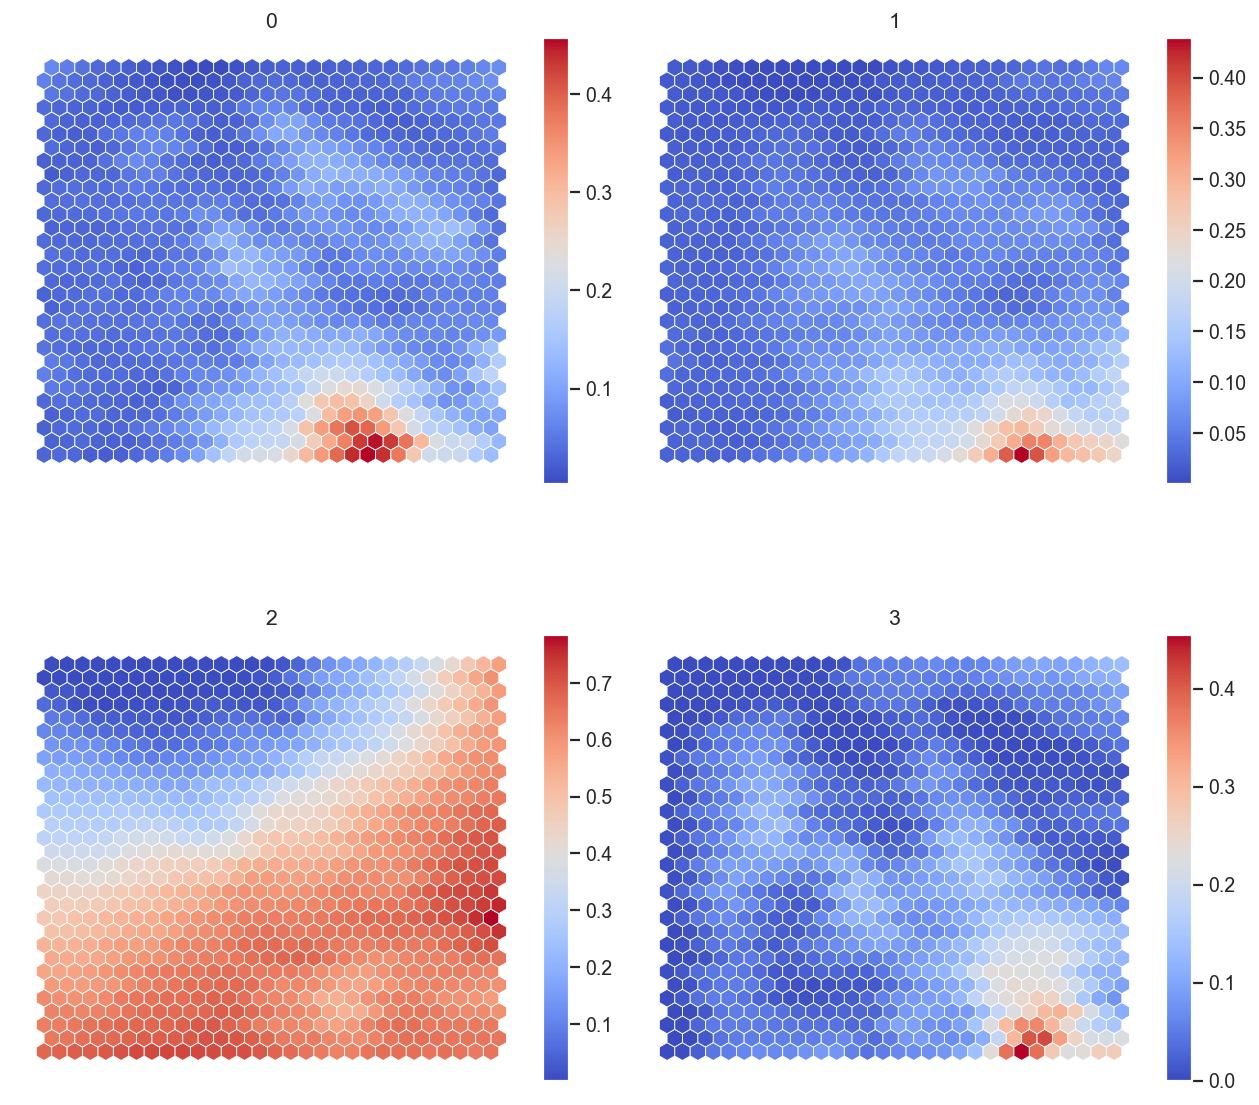

In [33]:
def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2)  
    y = j * (np.sqrt(3) / 2)
    return x, y

def plot_hexagons(som, ax, colornorm, matrix_vals, label="", cmap=cm.coolwarm, annot=False):
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):
            wx, wy = convert_map_to_euclidean(i, j)  
            hex = RegularPolygon(
                (wx, wy),
                numVertices=6,
                radius=np.sqrt(1 / 3),
                facecolor=cmap(colornorm(matrix_vals[i, j])),
                alpha=1,
                edgecolor="white",
                linewidth=0.5,
            )
            ax.add_patch(hex)
            if annot:
                annot_val = np.round(matrix_vals[i, j], 2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                ax.text(
                    wx,
                    wy,
                    annot_val,
                    ha="center",
                    va="center",
                    fontsize="x-small",
                )
    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)  
    sm = cm.ScalarMappable(cmap=cmap, norm=colornorm)
    sm.set_array([])  
    Colorbar(ax=cax, mappable=sm, orientation="vertical")

weights = som_best_behaviour.get_weights() 
features_to_plot = df_behaviour.columns[:4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=128)  
axes = axes.flatten()  

for idx, ax in enumerate(axes):
    if idx < len(features_to_plot):  
        matrix_vals = weights[:, :, idx]
        colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
        plot_hexagons(
            som_best_behaviour,
            ax,
            colornorm,
            matrix_vals,
            label=features_to_plot[idx],
            cmap=cm.coolwarm,
        )
    else: 
        ax.axis("off")

plt.tight_layout()
plt.show()

### U-matrix


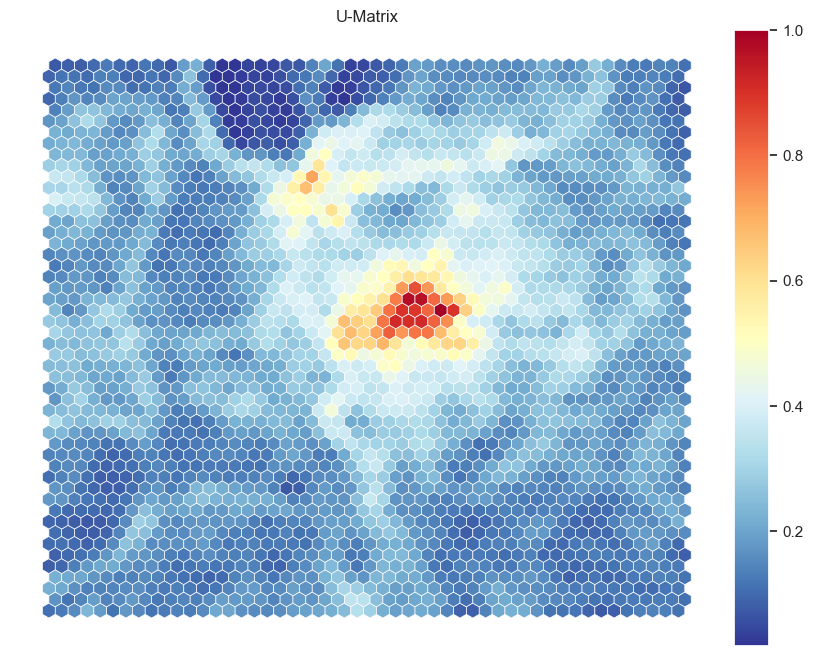

In [34]:
som_best_behaviour = MiniSom(
    x=50, y=50, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42)

som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000)

umatrix = som_best_behaviour.distance_map(scaling='mean') 

fig, ax = plt.subplots(figsize=(10, 8))  
colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

plot_hexagons(
    som_best_behaviour,
    ax, 
    colornorm,
    umatrix,
    label="U-Matrix",
    cmap=cm.RdYlBu_r)
plt.show()


### Hit-map


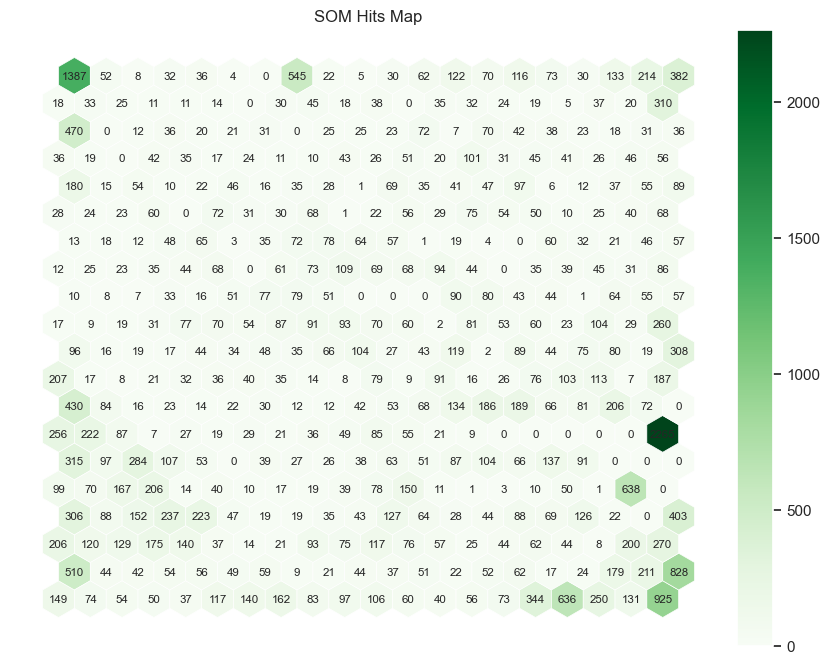

In [35]:
som_best_behaviour = MiniSom(
    x=20, y=20, input_len=som_data_behaviour.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)

som_best_behaviour.random_weights_init(som_data_behaviour)
som_best_behaviour.train_batch(som_data_behaviour, 20000)

hitsmatrix = som_best_behaviour.activation_response(df_behaviour.values) 
fig, ax = plt.subplots(figsize=(10, 8))  

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

plot_hexagons(som_best_behaviour, ax, colornorm, hitsmatrix, label="SOM Hits Map", cmap=cm.Greens,annot = True)
plt.show()

### K-Means on top of SOM units

In [36]:
weights_flat = som_best_behaviour.get_weights().reshape((20 * 20), 5)
print("Flattened SOM weights shape:", weights_flat.shape)

ValueError: cannot reshape array of size 2400 into shape (400,5)

In [ ]:
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=42)
nodeclus_labels = kmeans.fit_predict(weights_flat)

kmeans_matrix = nodeclus_labels.reshape((20, 20))
print("K-Means clustering completed.")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

colornorm = mpl_colors.Normalize(vmin=0, vmax=n_clusters - 1)

plot_hexagons(
    som_best_behaviour,
    ax,  
    colornorm,
    kmeans_matrix,
    label="K-Means Clusters on SOM",
    cmap=cm.Spectral)
plt.show()

### Hierarchical Clustering on top of SOM units

In [ ]:
weights_flat_behaviour = som_best_behaviour.get_weights().reshape((20 * 20), 4)

distance_matrix = pdist(weights_flat, metric='euclidean')  

linkage_matrix = linkage(distance_matrix, method='ward')  

n_clusters = 4
hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust') 

hierarchical_matrix_behaviour = hier_labels.reshape((20, 20))

fig, ax = plt.subplots(figsize=(10, 8))

colornorm = mpl_colors.Normalize(vmin=1, vmax=n_clusters)

plot_hexagons(
    som_best_behaviour,
    ax,
    colornorm,
    hierarchical_matrix_behaviour,
    label="SOM Hierarchical Clustering",
    cmap=cm.Spectral,  
)
plt.show()

In [ ]:
nodes_behaviour = weights_flat_behaviour

In [ ]:
df_nodes_behaviours = pd.DataFrame(nodes_behaviour, columns=df_behaviour.columns)
df_nodes_behaviours['label'] = nodeclus_labels
df_nodes_behaviours

In [ ]:
bmu_index_behaviour = np.array([som_best_behaviour.winner(x) for x in df_behaviour.values])

print(bmu_index_behaviour.shape)

bmu_index_behaviour

In [ ]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels_behaviour = [hierarchical_matrix_behaviour[i[0]][i[1]] for i in bmu_index_behaviour]


In [ ]:
df_final_behaviour = pd.concat([
                df_behaviour,
                pd.Series(som_final_labels_behaviour, name='label', index=df_behaviour.index)], axis=1)

df_final_behaviour

In [ ]:
df_final_behaviour[df_behaviour.columns.tolist()+['label']].groupby('label').mean()

In [ ]:
learning_rates = [0.3, 0.5, 0.7, 1.0]
sigmas = [1.0, 2.0, 3.0, 5.0]

results_after_df, best_config = run_multiple_soms(som_data_preferences, learning_rates, sigmas)

som_best_preferences = MiniSom(
    x=30, y=30, input_len=som_data_preferences.shape[1],
    sigma=best_config['Sigma'], learning_rate=best_config['Learning Rate'],
    neighborhood_function='gaussian', topology='hexagonal',
    random_seed=42
)
som_best_preferences.random_weights_init(som_data_preferences)
som_best_preferences.train_batch(som_data_preferences, 20000) 

<a class="anchor" id="mean">
    
## 3.4. Mean Shift Clustering
</a>

### 3.4.1. MSC - Defining the bandwith
Bandwidth is the window size used for the kernel density estimation.
This code estimates the optimal bandwidth to be used in Mean Shift clustering by considering the 40% closest points in the dataset, this will help understand around which values we should try the bandwidth around (a higher quantile means that we will have more points in the same clustering.

In [8]:
bandwidth = estimate_bandwidth(df_behaviour, quantile=0.4, random_state=1, n_jobs=-1)
bandwidth

0.3450647325457709

In [33]:
bandwidths = np.arange(0.2, 0.35, 0.025) 
results = []

for bw in bandwidths:
    ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=4)
    ms_labels = ms.fit_predict(df_behaviour)
    num_clusters = len(np.unique(ms_labels))

    df_behaviour_with_labels = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
    
    sil_score = silhouette_score(df_behaviour, ms_labels)
    
    r2_mean = get_r2(df_behaviour, ms_labels)
    
    results.append((bw, num_clusters, sil_score, r2_mean))
    
    print(f"Bandwidth: {bw:.3f}, Number of Clusters: {num_clusters}, Silhouette Score: {sil_score:.3f}, R^2: {r2_mean:.4f}")

Bandwidth: 0.20, Number of Clusters: 29, Silhouette Score: 0.260, R^2: 0.6679
Bandwidth: 0.23, Number of Clusters: 13, Silhouette Score: 0.359, R^2: 0.6278
Bandwidth: 0.25, Number of Clusters: 6, Silhouette Score: 0.334, R^2: 0.3690
Bandwidth: 0.28, Number of Clusters: 4, Silhouette Score: 0.404, R^2: 0.2133
Bandwidth: 0.30, Number of Clusters: 3, Silhouette Score: 0.441, R^2: 0.2013
Bandwidth: 0.32, Number of Clusters: 3, Silhouette Score: 0.444, R^2: 0.1953


### 3.4.2. MSC - Optimal amount of clusters
From the previous code, we conclude the best bandwith would be 0.3 because it has the best equilibrium between silhouete score and R^2. So we apply this to the following code.

In [12]:
ms = MeanShift(bandwidth=0.3, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_behaviour)

In [41]:
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(ms_labels, index=df_behaviour.index, name="ms_labels")], axis=1)

df_concat = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('labels').mean()
df_grouped

,0,1,2,3,4,5
labels,,,,,,
0,0.058160,0.043243,0.365980,0.052689,0.056976,0.097797
1,0.473381,0.690269,0.955556,0.722910,0.724599,0.505348
2,0.239898,0.283195,0.876624,0.282708,0.286184,0.446118


In [14]:
r2 = get_r2(df_behaviour, ms_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, ms_labels)
print(f"Silhouette Score: {silhouete}")

R^2 Score: 0.20133236745784405
Silhouette Score: 0.44126780891468037


In [15]:
mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Mean-Shift"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

C:\Users\joana\AppData\Local\Temp\ipykernel_11836\1371183887.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)


<a class="anchor" id="dbscan">
    
## 3.5. DBSCAN
</a>

### 3.5.1. DBSCAN - determine the eps
To understand the best eps value for our DBSCAN, we do a K-Distance graph:
- The **K-Distance graph** shows how the distance to the 20th nearest neighbor changes for each point.
- On the left, the distances are small, meaning points are close and form dense clusters.
- To the right, the distances increase, indicating points are becoming more spread out and sparse.
- The **"elbow"** is where the graph's slope increases sharply — this marks the transition from dense clusters to sparse points.

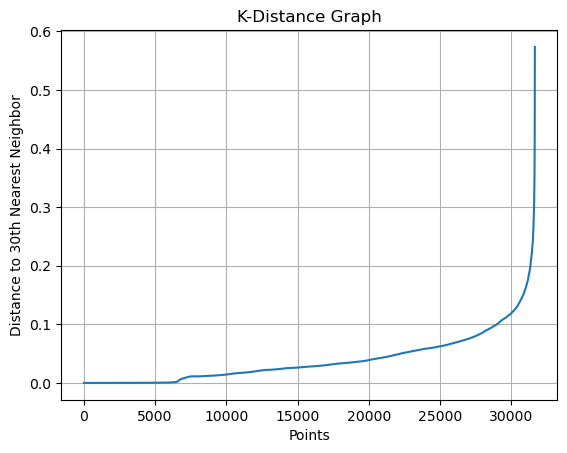

In [34]:
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_behaviour)

distances, _ = neigh.kneighbors(df_behaviour)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 30th Nearest Neighbor')
plt.title('K-Distance Graph')
plt.grid(True) 
plt.show()


### 3.5.2. DBSCAN - optimal number
From the previous graph we are able to conclude that the ideal **`eps`** is around 1 and 2 eps, so we choose 1.5 for this variable.

In [17]:
# # Perform DBSCAN clustering
# dbscan = DBSCAN(eps=2, min_samples=30, n_jobs=4)
# dbscan_labels = dbscan.fit_predict(df_behaviour)

# dbscan_n_clusters = len(np.unique(dbscan_labels))
# print("Number of estimated clusters : %d" % dbscan_n_clusters)

This clustering won't be used nor analysed further because:
- Too computationaly expensive
- The results are not the best (forms 2 clusterings, one of noise and the other one of not noise)
- Its biggest strenght is being used in the removal of outliers.

<a class="anchor" id="gmm">
    
## 3.6. Gaussian Mixture
</a>

### 3.6.1. GMM - Determining number of clusters
For this we will use a plot that determines the optimal number of components (`n_components`) for a Gaussian Mixture Model (GMM) by comparing the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
  - **X-axis**: Represents the number of components in the GMM, ranging from 1 to 15.  
  - **Y-axis**: Shows the AIC and BIC scores. Lower values on the y-axis indicate better models based on the respective criteria.  

- **AIC (Akaike Information Criterion)**:  
  - Measures the goodness of fit while penalizing for model complexity.  
  - Lower AIC values signify a better balance between model complexity and fit.

- **BIC (Bayesian Information Criterion)**:  
  - Similar to AIC but applies a stronger penalty for complexity, favoring simpler models.  
  - Lower BIC values indicate the preferred model under this criterion.

- **Elbow Point in the Curve**: at **3 components**, because it's where the curve starts to flatten, suggesting that adding more components beyond this range provides diminishing improvements in model fit.

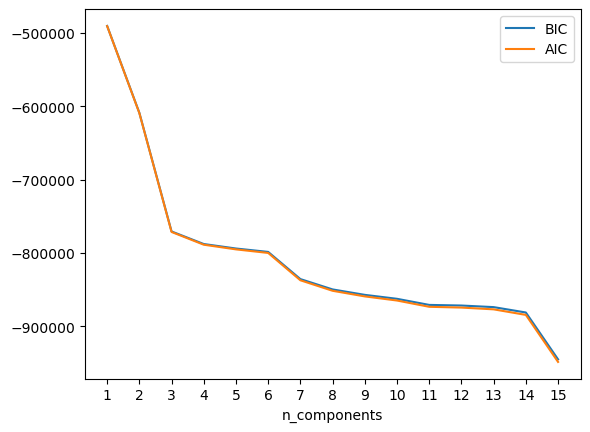

In [22]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_behaviour)
          for n in n_components]

bic_values = [m.bic(df_behaviour) for m in models]
aic_values = [m.aic(df_behaviour) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

### 3.6.2 GMM - Optimal number of clusters
As previously seen the optimal number of clusters for this algorithm is 3, this way we will continue with this value.

In [44]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_behaviour)

In [26]:
#proportion of the data that belongs to each cluster
gmm.weights_

array([0.21627032, 0.22887962, 0.55485006])

In [31]:
df_concat = pd.concat([df_behaviour, pd.Series(gmm_labels, name='gmm_labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('gmm_labels').mean()
df_grouped

,0,1,2,3,4,5
gmm_labels,,,,,,
0,0.025115,0.004655,0.000000,0.015433,0.016063,0.000000
1,0.159101,0.159791,0.728706,0.158703,0.165993,0.266028
2,0.047465,0.034146,0.408670,0.046486,0.050893,0.100164


In [45]:
r2 = r2(df_behaviour, gmm_labels)
print(f"R^2 Score: {r2}")
silhouete = silhouette_score(df_behaviour, gmm_labels)
print(f"Silhouette Score: {silhouete}")

R^2 Score: 0.5262381904970271
Silhouette Score: 0.2068986593782317


In [37]:
mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Gaussian Mixture"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

## 3.7. Clustering assessment
To measure the different clustering algorithms used, we use the following metrics:
- **R^2:** explains how well the clustering algorithm explains the variance in the data. A higher R² value indicates that the clustering model better fits the data, with fewer unexplained variations.
- **Sillhouete Score:** measures how similar each point is to its own cluster compared to other clusters. It ranges from -1 to +1, where a score closer to +1 indicates well-defined clusters, and values closer to -1 suggest poor clustering. A higher silhouette score generally implies better clustering quality.

This way, we want to choose the clustering algorithm that shows the best balance between both metrics.ity.

In [42]:
results_df

,Silhouette_Score,R2
KMeans_2,0.464714,0.529229
KMeans_2,0.434698,0.724775
KMeans_2,0.545936,0.630808
KMeans_3,0.460286,0.744115
HC_2,0.464714,0.529229
HC_3,0.434698,0.724775
